In [130]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import optuna

from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import fetch_california_housing
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

### 1. Получите и загрузите данные.

In [103]:
california_housing = fetch_california_housing()
X = california_housing.data
y = california_housing.target

In [104]:
data = pd.DataFrame(data=X, columns=california_housing.feature_names)
data['MedHouseVal'] = y
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### 2. Проведите первичный анализ.
- a.Проверьте данные на пропуски. Удалите в случае обнаружения.
- b.*Нормализуйте один из признаков.

In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [106]:
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [107]:
data.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [109]:
data.duplicated().sum()

0

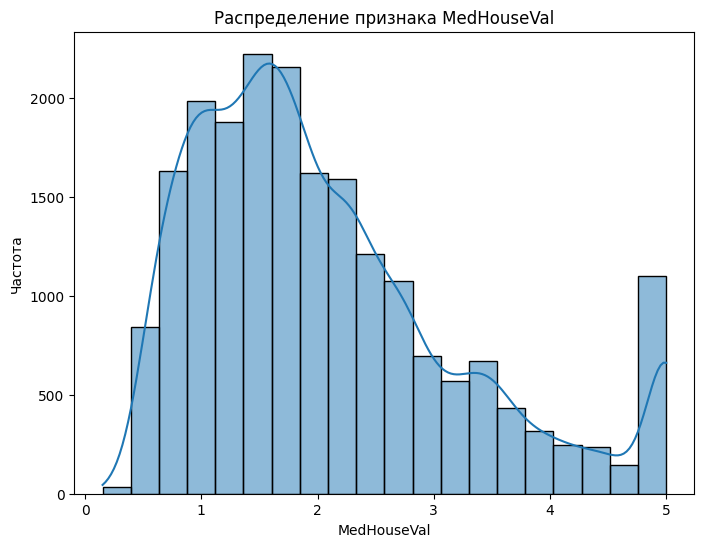

In [110]:
plt.figure(figsize=(8, 6))
sns.histplot(data['MedHouseVal'], bins=20, kde=True)
plt.title("Распределение признака MedHouseVal")
plt.xlabel("MedHouseVal")
plt.ylabel("Частота")
plt.show()

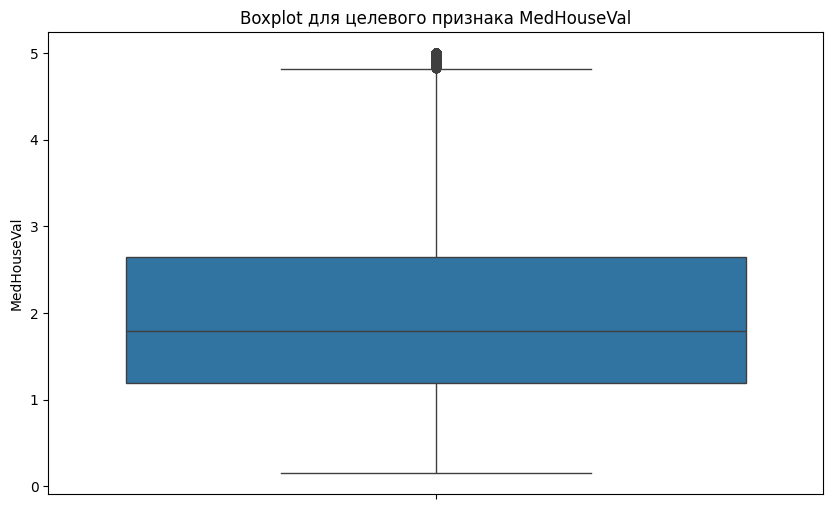

In [111]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data['MedHouseVal'])
plt.title("Boxplot для целевого признака MedHouseVal")
plt.show()

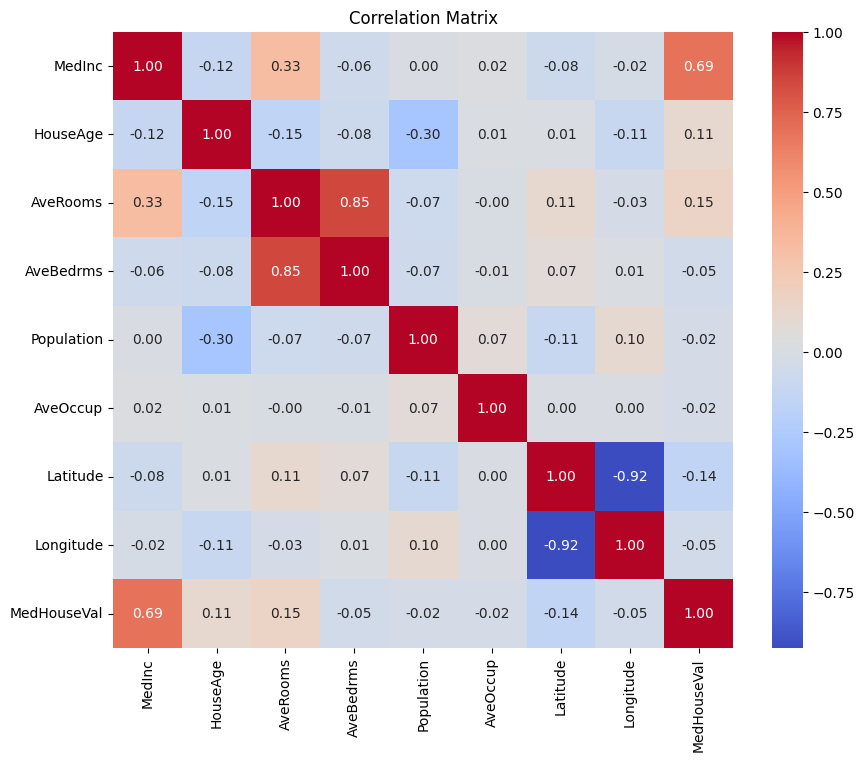

In [112]:
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

В данном случае пропусков нет, поэтому нет необходимости в их удалении.

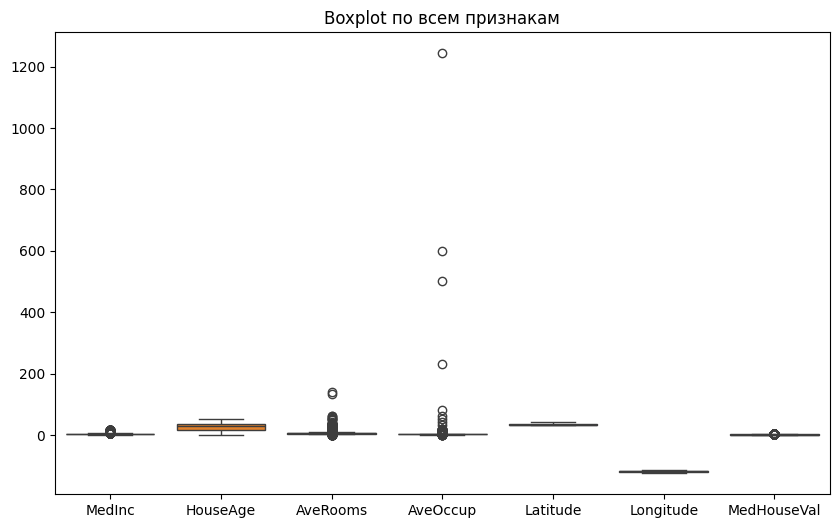

In [113]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']])
plt.title("Boxplot по всем признакам")
plt.show()

In [114]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

data_no_outliers = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

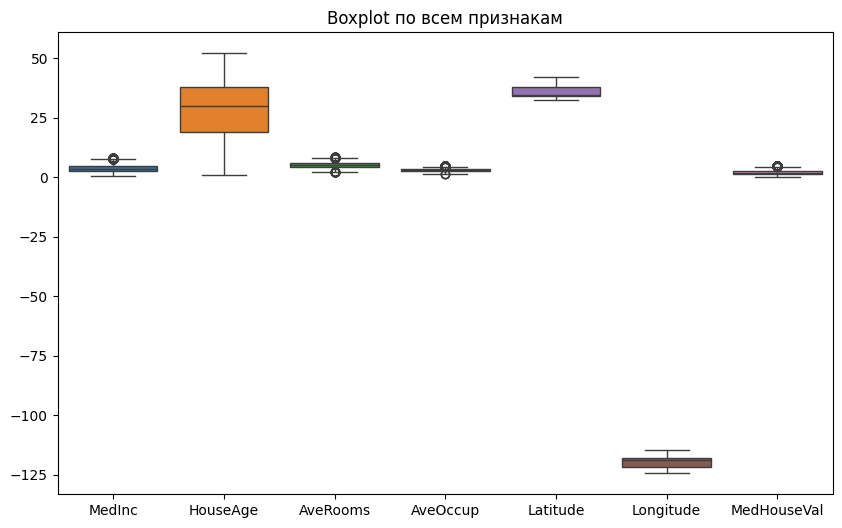

In [115]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_no_outliers[['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']])
plt.title("Boxplot по всем признакам")
plt.show()

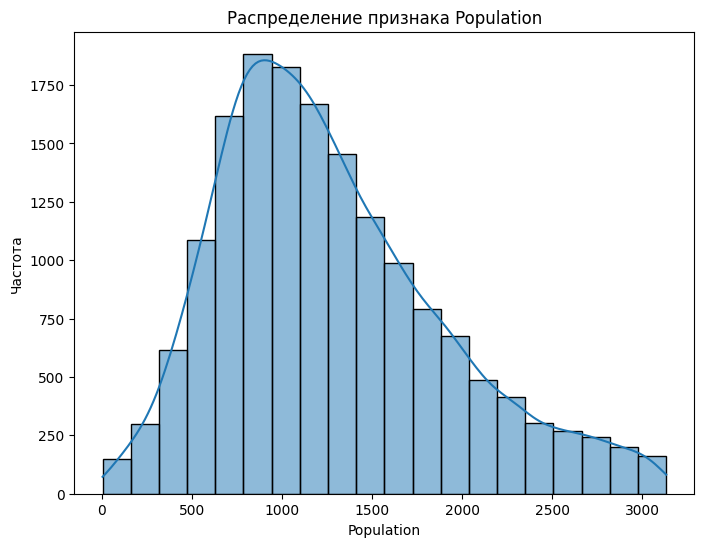

In [116]:
plt.figure(figsize=(8, 6))
sns.histplot(data_no_outliers['Population'], bins=20, kde=True)
plt.title("Распределение признака Population")
plt.xlabel("Population")
plt.ylabel("Частота")
plt.show()

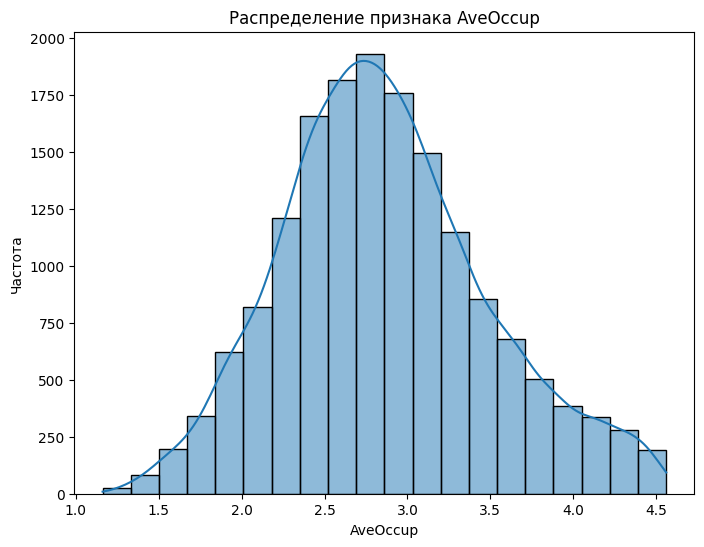

In [117]:
plt.figure(figsize=(8, 6))
sns.histplot(data_no_outliers['AveOccup'], bins=20, kde=True)
plt.title("Распределение признака AveOccup")
plt.xlabel("AveOccup")
plt.ylabel("Частота")
plt.show()

### 3. Разделите выборку на обучающее и тестовое подмножества. 80% данных оставить на обучающее множество, 20% - на тестовое.

In [118]:
X = data_no_outliers.drop(columns=['MedHouseVal'])
y = data_no_outliers['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [119]:
sc = StandardScaler()
X_train[['Population', 'AveOccup']] = sc.fit_transform(X_train[['Population', 'AveOccup']])
X_test[['Population', 'AveOccup']] = sc.transform(X_test[['Population', 'AveOccup']])

### 4. Обучите модель регрессии на обучающем множестве.

In [120]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [121]:
X_test

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
107,3.1691,52.0,4.165877,1.090047,-0.932479,-1.986689,37.81,-122.25
4989,1.9792,47.0,4.816770,1.124224,0.094607,2.029457,34.00,-118.31
8000,4.6019,36.0,5.235732,1.032258,-0.226457,-0.102955,33.85,-118.13
8624,5.0602,34.0,5.960912,1.026059,-0.715241,-0.297977,33.88,-118.38
5,4.0368,52.0,4.761658,1.103627,-1.368551,-1.161054,37.85,-122.25
...,...,...,...,...,...,...,...,...
19842,1.8801,26.0,4.634465,1.086162,-0.084294,0.504729,36.42,-119.10
19360,3.2546,32.0,5.041121,0.988785,0.235173,-0.344413,38.79,-123.01
20042,4.0833,41.0,6.598592,1.112676,-1.395706,-0.119450,36.06,-119.00
16061,4.3281,49.0,5.825623,1.081851,-0.863794,-0.431571,37.76,-122.49


In [122]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

### 5. Для тестового множества предскажите целевую переменную и сравните с истинным значением, посчитав точность предсказания модели. Для этого используйте встроенную функцию score.

In [123]:
lr_pred_train = model.score(X_train, y_train)
lr_pred_test = model.score(X_test, y_test)

In [124]:
print("Точность на train выборке предсказания модели регрессии:", lr_pred_train)
print("Точность на test выборке предсказания модели регрессии:", lr_pred_test)

Точность на train выборке предсказания модели регрессии: 0.638629582156033
Точность на test выборке предсказания модели регрессии: 0.637896437482156


In [144]:
lr_mse = mean_squared_error(y_test, y_test_pred)
lr_mse

0.3165222770544476

### 6. Обучите дерево решений на обучающем множестве.
- a. Повторите п. 5 для полученной модели.
- b. Визуализируйте часть дерева решений. Убедитесь, что график получился читабельным. Посмотрите примеры визуализации по ссылке.

In [127]:
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [138]:
tree_pred = decision_tree_model.predict(X_test)

In [129]:
tree_pred_train = decision_tree_model.score(X_test, y_test)
tree_pred_test = decision_tree_model.score(X_test, y_test)
print("Точность на train выборке деревьев решений:", tree_pred_train)
print("Точность на test выборке деревьев решений:", tree_pred_test)

Точность на train выборке деревьев решений: 0.5252329044243378
Точность на test выборке деревьев решений: 0.5252329044243378


In [143]:
tree_mse = mean_squared_error(y_test, tree_pred)
tree_mse

0.41500382133006436

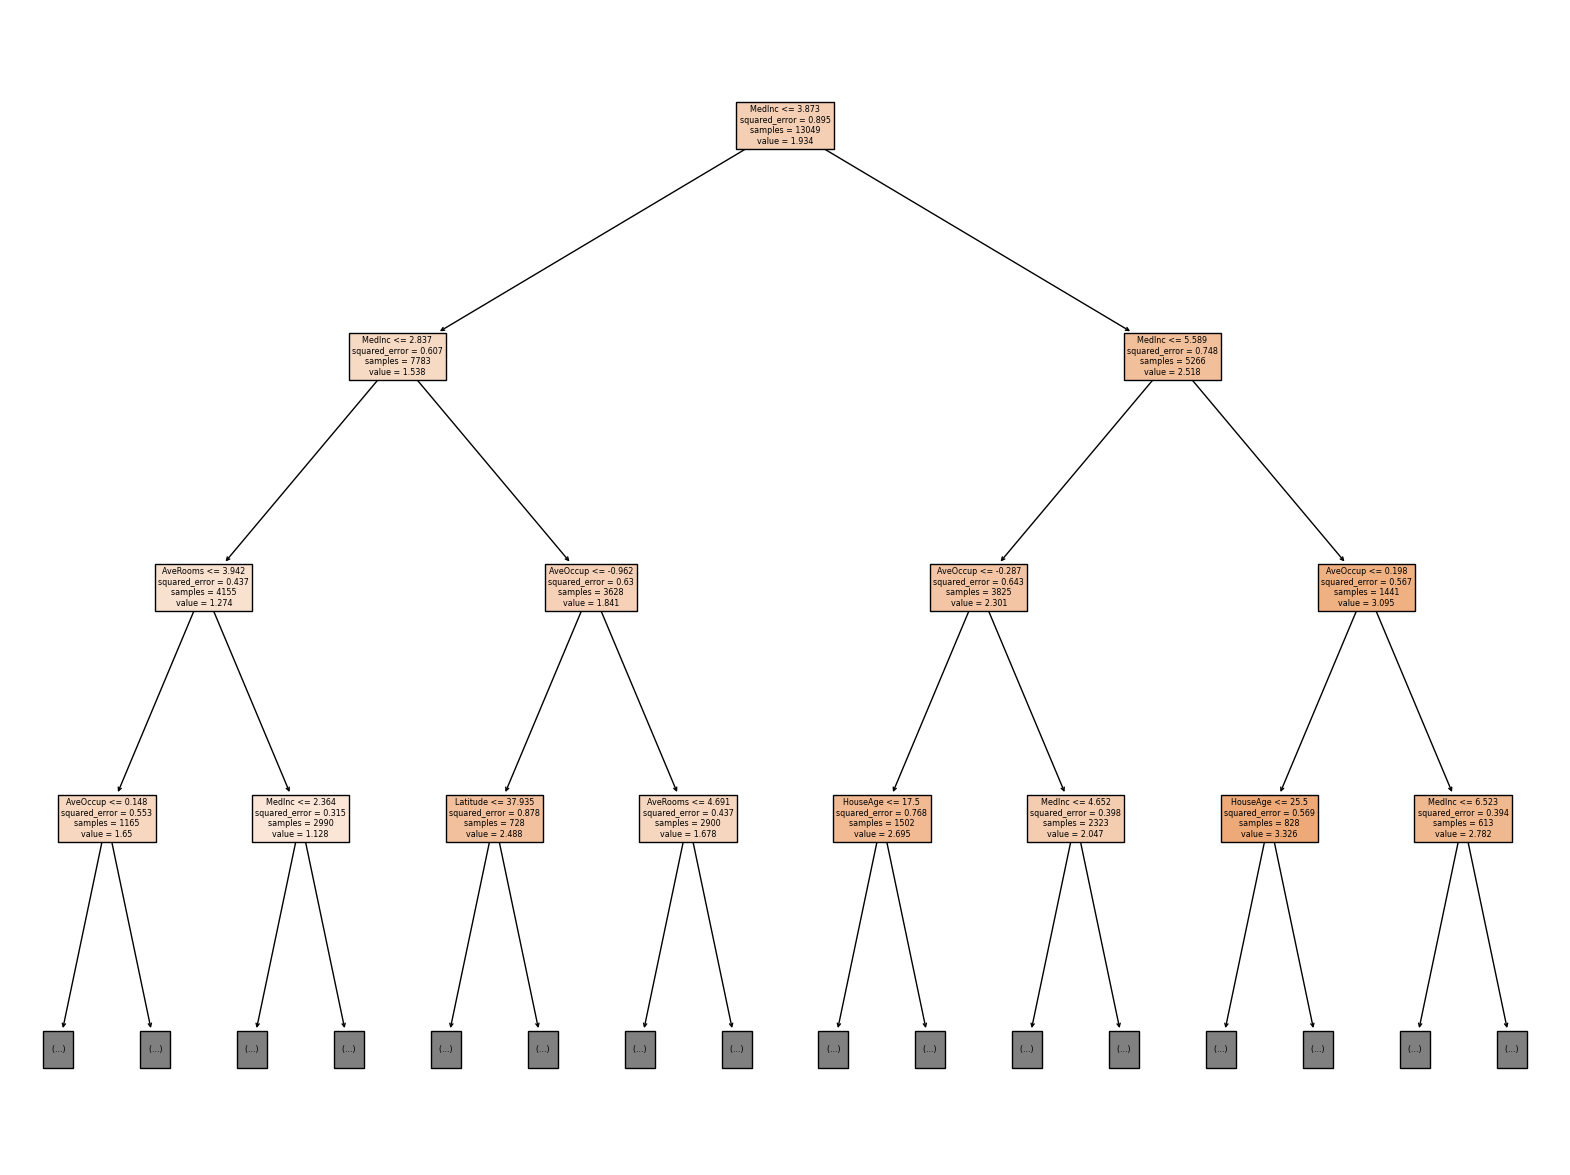

In [132]:
plt.figure(figsize=(20, 15))
plot_tree(decision_tree_model, max_depth=3, feature_names=X.columns, filled=True)
plt.show()

### 7. Оптимизируйте глубину дерева (max_depth). *Оптимизируйте ещё один параметр модели на выбор.
- a. Повторите п. 5 для полученной модели.

In [133]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Лучшие параметры:", best_params)

[I 2024-05-15 21:40:49,196] A new study created in memory with name: no-name-c0196f3a-c5e5-4144-bd90-d6d58eaa6669
[I 2024-05-15 21:40:49,229] Trial 0 finished with value: 0.39706186558946505 and parameters: {'max_depth': 5, 'min_samples_split': 3}. Best is trial 0 with value: 0.39706186558946505.
[I 2024-05-15 21:40:49,293] Trial 1 finished with value: 0.32500534733079917 and parameters: {'max_depth': 12, 'min_samples_split': 12}. Best is trial 1 with value: 0.32500534733079917.
[I 2024-05-15 21:40:49,327] Trial 2 finished with value: 0.39706186558946505 and parameters: {'max_depth': 5, 'min_samples_split': 16}. Best is trial 1 with value: 0.32500534733079917.
[I 2024-05-15 21:40:49,400] Trial 3 finished with value: 0.3285217473040216 and parameters: {'max_depth': 21, 'min_samples_split': 16}. Best is trial 1 with value: 0.32500534733079917.
[I 2024-05-15 21:40:49,485] Trial 4 finished with value: 0.3925023643903136 and parameters: {'max_depth': 21, 'min_samples_split': 3}. Best is tri

Лучшие параметры: {'max_depth': 8, 'min_samples_split': 7}


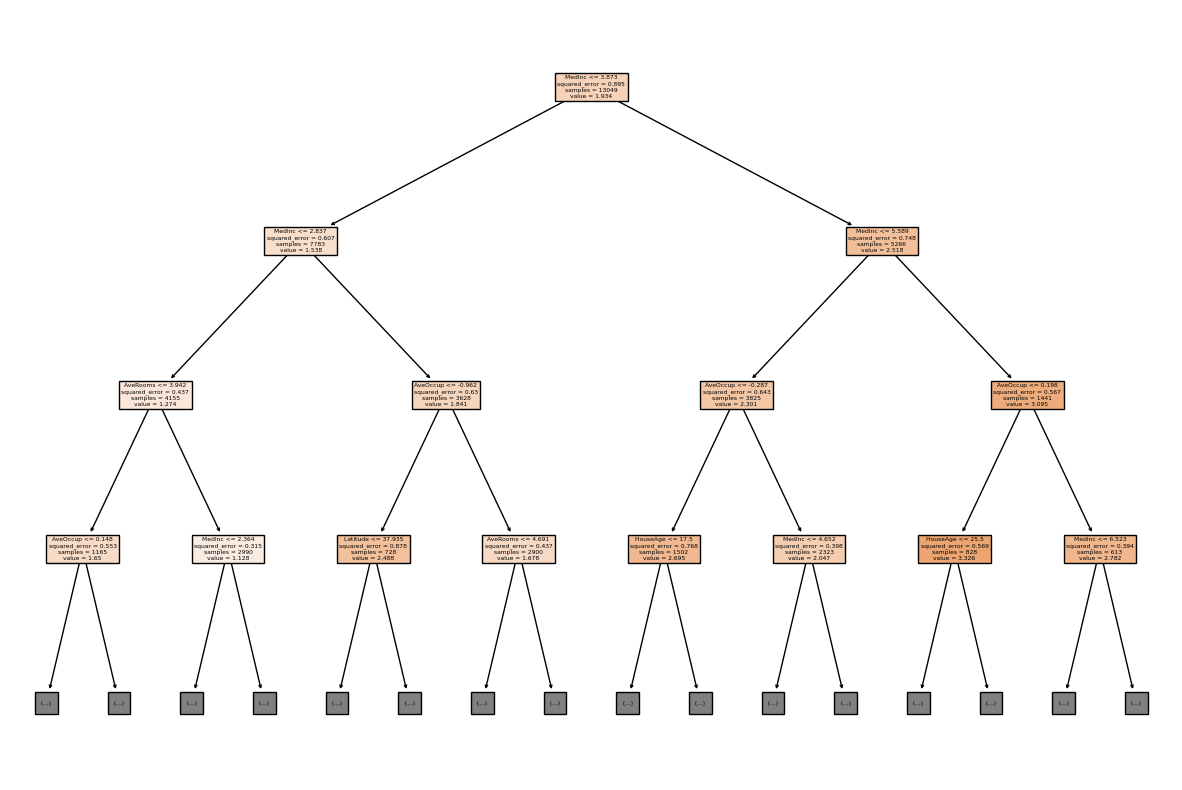

In [134]:
best_decision_tree_model = DecisionTreeRegressor(**best_params, random_state=42)
best_decision_tree_model.fit(X_train, y_train)

plt.figure(figsize=(15, 10))
plot_tree(best_decision_tree_model, max_depth=3, feature_names=X.columns, filled=True)
plt.show()

In [140]:
best_tree_pred = best_decision_tree_model.predict(X_test)

In [135]:
best_tree_pred_train = best_decision_tree_model.score(X_test, y_test)
best_tree_pred_test = best_decision_tree_model.score(X_test, y_test)
print("Точность на train выборке деревьев решений:", best_tree_pred_train)
print("Точность на test выборке деревьев решений:", best_tree_pred_test)

Точность на train выборке деревьев решений: 0.6513648066502455
Точность на test выборке деревьев решений: 0.6513648066502455


In [142]:
best_mse = mean_squared_error(y_test, best_tree_pred)
best_mse

0.3047492946301624

### 8. Сформулируйте выводы по проделанной работе.
- a. Сравните точность двух моделей.
- b. Напишите свое мнение, для каких задач предпочтительнее использовать обученные в работе модели? Какие у них есть плюсы и минусы?

- Лучше себя показали деревья решений с подбором гиперпараметров, по таблице ниже это видно
- Линейные модели лучше подходят для задач, в которых присутствует линейная зависимость между признаками и таргетом, а вот деревья решений можно использовать и при нелинейных взаимосвязях. Большой минус деревьев - склонность к переобучению, плюс если происходят минимальные изменения в данных - модель может себя повести непредсказуемо.

In [145]:
data = {
    'Model': ['LinearRegression', 'DesisionTree без гипертюнинга', 'DesicionTree с гипертюнингом'],
    'MSE': [lr_mse, tree_mse, best_mse]
}

In [146]:
metrics_df = pd.DataFrame(data)
metrics_df

,Model,MSE
0,LinearRegression,0.316522
1,DesisionTree без гипертюнинга,0.415004
2,DesicionTree с гипертюнингом,0.304749
